In [1]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import graphviz
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import ttest_ind, pearsonr


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


import warnings
warnings.filterwarnings("ignore")
import prep



# Acquisition


In [2]:
# Get churn data from customers table
df = pd.read_csv('telco_churn_customers.csv')
df = prep.prep_telco(df)

In [3]:
df.drop(columns='customer_id', axis=1, inplace=True)

In [4]:
def peekatdata(dataframe):
    head_df = df.head()
    tail_df = df.tail()
    head_tail = head_df.append(tail_df)
    print('Head and Tail\n\n', head_tail)
    print('--'*55)
    shape_tuple = df.shape
    print('Shape\n\n', shape_tuple)
    print('--'*20)
    describe_df = df.describe()
    print('Describe\n\n', describe_df)
    print('--'*20)
    print('Index\n\n', df.index)
    print('--'*20)
    print('Data Types\n\n', df.dtypes)
    print('--'*20)
    print('Null Value Count\n\n', df.isnull().sum())
    print('--'*55)
    print('Memory\n\n', df.memory_usage)

# Data Prep


In [5]:
def df_value_counts(df):
    for col in df.columns: 
        n = df[col].unique().shape[0] 
        col_bins = min(n,10) 
        if df[col].dtype in ['int64','float64'] and n > 10:
            print('%s:' % col)
            print(df[col].value_counts(bins=col_bins, sort=False)) 
        else: 
            print(df[col].value_counts()) 
        print('\n')


### Missing Values

We only found a few missing values in the total_charges column where tenure was 0. There was an empty string in that field so we replaced it with a 0 since a customer with 0 tenure would have 0 total charges due.



In [6]:
# Split the data into train (70%) & test (30%) samples.
X = df.drop(['churn'], axis=1)
y = df[['churn']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.30, random_state=123)


In [7]:
# Numeric Scaling: scale the monthly_charges and total_charges data. Make sure that the parameters for scaling 
# are learned from the training data set.
scaler = MinMaxScaler()
scaler.fit(X_train[['monthly_charges', 'total_charges']])

X_train[['monthly_charges', 'total_charges']] = scaler.transform(X_train[['monthly_charges', 'total_charges']])
X_test[['monthly_charges', 'total_charges']] = scaler.transform(X_test[['monthly_charges', 'total_charges']])

In [8]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

# Data Exploration


Are there features that indicate a higher propensity to churn? like type of internet service, type of phone service, online security and backup, senior citizens, paying more than x% of customers with the same services, etc.?

- A few of the features have a much higher percentage for churn:
- internet_service_type_id, contract_type_id, payment_type_id, device_protection, tech_support, senior_citizen

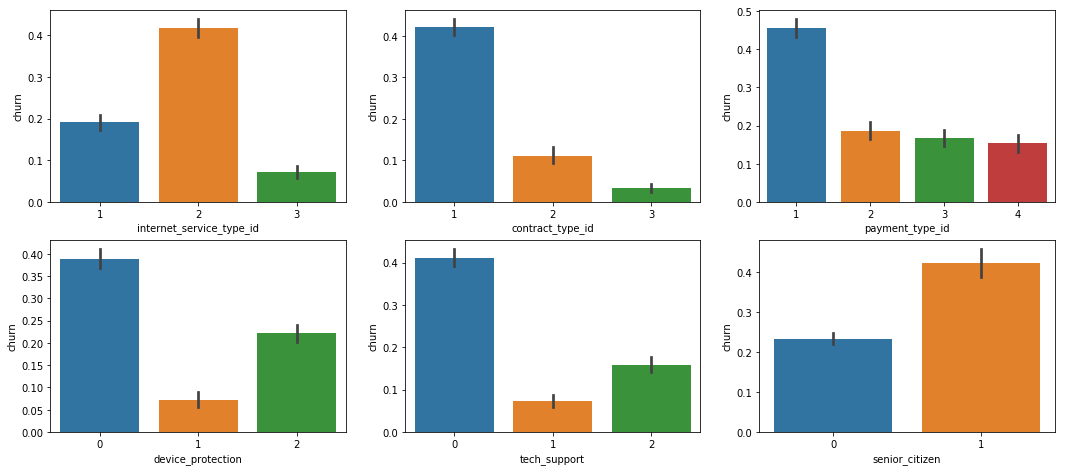

In [9]:
plt.figure(figsize=(18,12))

plt.subplot(331)
sns.barplot(x=train.internet_service_type_id, y=train.churn)

plt.subplot(332)
sns.barplot(x=train.contract_type_id, y=train.churn)

plt.subplot(333)
sns.barplot(x=train.payment_type_id, y=train.churn)

plt.subplot(334)
sns.barplot(x=train.device_protection, y=train.churn)

plt.subplot(335)
sns.barplot(x=train.tech_support, y=train.churn)

plt.subplot(336)
sns.barplot(x=train.senior_citizen, y=train.churn)

Is there a price threshold for specific services where the likelihood of churn increases once price for those services goes past that point? If so, what is that point for what service(s)?

Controlling for services (phone_id, internet_service_type_id, online_security_backup, device_protection, tech_support, and contract_type_id), is the mean monthly_charges of those who have churned significantly different from that of those who have not churned? (Use a t-test to answer this.)

- statistic: 13.57
- pvalue: 3.18e-41
- From the TTest we can conclude there is a significantly difference between the two.

In [10]:
# Getting customers who have duplicate services.

dups = train[train.duplicated(['phone_id', 
                               'internet_service_type_id', 
                               'online_security_backup',
                               'device_protection', 
                               'tech_support', 
                               'contract_type_id'],
                                keep=False)]


In [11]:
# Finding the monthly_charges for the ones who have churned/not

churn = dups.loc[dups['churn'] == 1]['monthly_charges']
no_churn = dups.loc[dups['churn'] == 0]['monthly_charges']

In [12]:
# T test on the mean monthly_charges

ttest_ind(churn,no_churn)

Ttest_indResult(statistic=13.572727810028752, pvalue=3.1820164059683664e-41)

How much of monthly_charges can be explained by internet_service_type? (hint: correlation test). State your hypotheses and your conclusion clearly.

- hypotheses: The internet_service_type will have an impact on the amount of monthly_charges. 
- conclusion: 31.9% of the varriance in monthly_charges can be explained by the internet_service_type.

In [13]:
pearsonr(train.monthly_charges, train.internet_service_type_id)

(-0.3190060938742721, 5.058686301357775e-117)

How much of monthly_charges can be explained by internet_service_type + phone service type (0, 1, or multiple lines). State your hypotheses and your conclusion clearly.

In [14]:
train.head()

,senior_citizen,tenure,internet_service_type_id,contract_type_id,payment_type_id,monthly_charges,total_charges,tenure_year,household_type_id,streaming_services,phone_id,online_security_backup,gender,device_protection,tech_support,paperless_billing,churn
1479,0,12,2,1,3,0.613930,0.120141,1.00,0,1,1,1,1,0,0,1,0
2377,1,22,1,1,2,0.450746,0.159106,1.83,2,0,2,4,0,0,2,1,0
6613,0,69,3,3,4,0.063184,0.193217,5.75,0,0,2,0,0,1,1,0,0
6468,0,71,3,3,3,0.067164,0.201847,5.92,2,0,2,0,0,1,1,0,0
2668,1,13,2,1,1,0.764179,0.148535,1.08,0,3,2,1,0,0,0,1,1


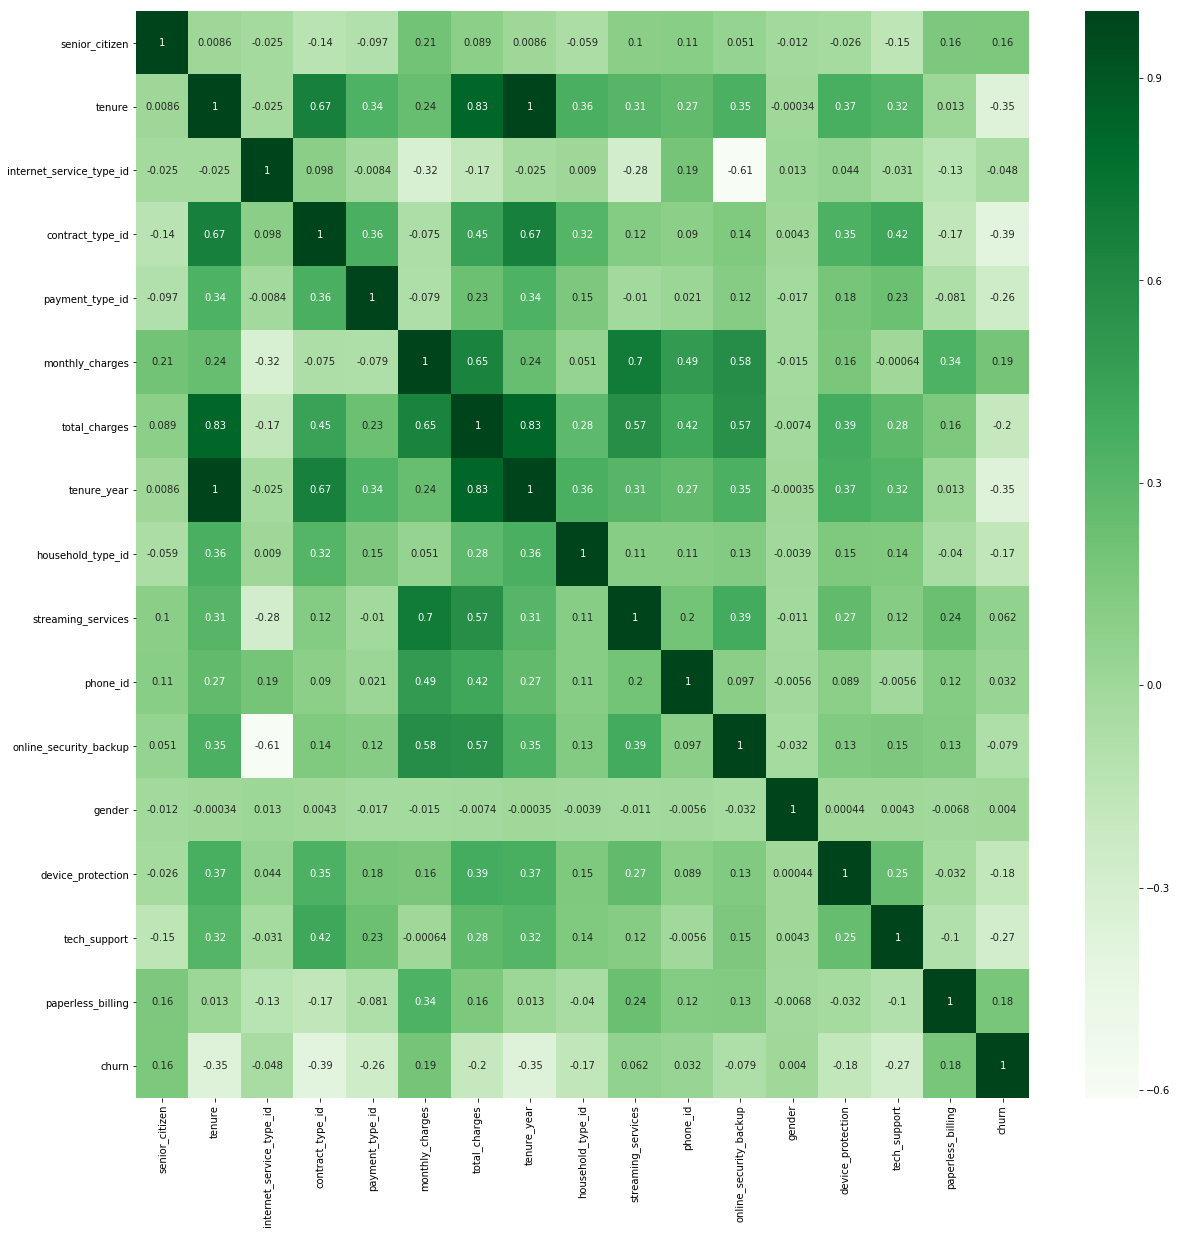

In [15]:
plt.figure(figsize=(20,20))
sns.heatmap(train.corr(), annot=True, cmap='Greens')

In [16]:
# scatter = pd.scatter_matrix(
#     train.drop(['customer_id'], axis=1), marker='o', s=40,
#     hist_kwds={'bins':15},  figsize=(25,25))

In [39]:
# sns.swarmplot(data=train, x='contract_type_id', y='monthly_charges', hue='churn')
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


In [33]:
# sns.pairplot(data=train)

In [41]:
# sns.relplot(data=train, x='tenure', y='total_charges', hue='churn')

In [50]:
# sns.boxplot(data=train[['monthly_charges', 'total_charges']])


In [18]:
# with sns.axes_style('white'):
#     j = sns.jointplot("monthly_charges", "churn", data=train, kind='reg', height=5);
#     j.annotate(pearsonr)
# plt.show()

In [19]:
# g = sns.PairGrid(train)
# g.map_diag(plt.hist)
# g.map_offdiag(plt.scatter);

# Modeling

### Logistic Regression

In [20]:
logis = LogisticRegression()
logis.fit(X_train, y_train)
y_pred_logis = logis.predict(X_train)
print('Accuracy of Logistic Regression classifier on training set: {:.2f}'
     .format(logis.score(X_train, y_train)))

Accuracy of Logistic Regression classifier on training set: 0.80


In [21]:
print(confusion_matrix(y_train, y_pred_logis))


[[3262  366]
 [ 617  685]]


In [22]:
print(classification_report(y_train, y_pred_logis))


              precision    recall  f1-score   support

           0       0.84      0.90      0.87      3628
           1       0.65      0.53      0.58      1302

   micro avg       0.80      0.80      0.80      4930
   macro avg       0.75      0.71      0.73      4930
weighted avg       0.79      0.80      0.79      4930



### Decision Tree

In [23]:
dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)
y_pred_dtc = dtc.predict(X_train)
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(dtc.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 1.00


In [24]:
print(confusion_matrix(y_train, y_pred_dtc))


[[3627    1]
 [  10 1292]]


In [25]:
print(classification_report(y_train, y_pred_dtc))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3628
           1       1.00      0.99      1.00      1302

   micro avg       1.00      1.00      1.00      4930
   macro avg       1.00      1.00      1.00      4930
weighted avg       1.00      1.00      1.00      4930



### Random Forest


In [26]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_pred_rfc = rfc.predict(X_train)
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rfc.score(X_train, y_train)))


Accuracy of random forest classifier on training set: 0.98


In [27]:
print(confusion_matrix(y_train, y_pred_rfc))


[[3619    9]
 [  76 1226]]


In [28]:
print(classification_report(y_train, y_pred_rfc))


              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3628
           1       0.99      0.94      0.97      1302

   micro avg       0.98      0.98      0.98      4930
   macro avg       0.99      0.97      0.98      4930
weighted avg       0.98      0.98      0.98      4930



### KNN

In [29]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred_knn = knn.predict(X_train)
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))

Accuracy of KNN classifier on training set: 0.84


In [30]:
print(confusion_matrix(y_train, y_pred_knn))


[[3330  298]
 [ 499  803]]


In [31]:
print(classification_report(y_train, y_pred_knn))


              precision    recall  f1-score   support

           0       0.87      0.92      0.89      3628
           1       0.73      0.62      0.67      1302

   micro avg       0.84      0.84      0.84      4930
   macro avg       0.80      0.77      0.78      4930
weighted avg       0.83      0.84      0.83      4930

